# Hyperparameter Tuning

This notebook performs hyperparameter optimisation on the top three baseline models identified previously: Gradient Boosting, Random Forest, and XGBoost.

1. RandomSearchCV to explore a broad hyperparameter space
2. GridSearchCV centred around the best parameters for fine optimisation


## 1. Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator
from xgboost import XGBRegressor
from typing import Dict, Any

## 2. Data Loading and Preprocessing

Load the training data and apply initial filtering to remove invalid entries. Split the data into features and target.

In [ ]:
df = pd.read_csv("../data/CW1_train.csv")
df = df[(df["x"] > 0) & (df["y"] > 0) & (df["z"] > 0) & (df["y"] <= 10)]

X = df.drop(columns=["outcome"])
Y = df["outcome"]

## 3. Pipeline Builder

In [11]:
from pathlib import Path
import sys

current_directory = Path().resolve()
if current_directory.name == "notebooks":
    project_root = current_directory.parent
elif (current_directory / "src").exists():
    project_root = current_directory
else:
    project_root = current_directory.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.pipeline import build_pipeline

In [12]:
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
random_forest_parameters = {
    "model__n_estimators": [200, 400, 600, 800],  
    "model__max_depth": [None, 8, 12, 16, 20],          
    "model__min_samples_split": [2, 4, 6, 8, 10],      
    "model__min_samples_leaf": [1, 2, 4, 6],           
    "model__max_features": ["sqrt", "log2", 0.8, None],
    "model__bootstrap": [True, False]               
}


gradient_boosting_parameters = {
    "model__n_estimators": [200, 400, 600, 800, 1000],
    "model__max_depth": [3, 4, 5, 6, 8],             
    "model__learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1],  
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__min_samples_split": [2, 5, 10],           
    "model__min_samples_leaf": [1, 2, 4]          
}

extreme_gradient_boosting_parameters = {
    "model__n_estimators": [400, 600, 800, 1000, 1200],  
    "model__max_depth": [3, 4, 5, 6, 7],                 
    "model__learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "model__min_child_weight": [1, 3, 5, 7, 10],        
    "model__gamma": [0, 0.1, 0.2, 0.3, 0.5],            
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],      
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__reg_alpha": [0, 0.01, 0.1, 0.5, 1],         
    "model__reg_lambda": [1, 1.5, 2, 3, 5],             
}


In [ ]:
def random_search(model: BaseEstimator, parameters: Dict[str, Any], name: str):
    pipeline = build_pipeline(model)
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        n_iter=50,
        cv=cross_validation,
        scoring="r2",
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X, Y)
    
    print(f"{name} Random Search Best R²: {search.best_score_:.4f}")
    print(f"{name} Best Params: {search.best_params_}")
    
    return search

In [15]:
models_to_tune = {
    "Random Forest": (
        RandomForestRegressor(random_state=42, n_jobs=-1), random_forest_parameters
    ),
    "Gradient Boosting": (
        GradientBoostingRegressor(random_state=42), gradient_boosting_parameters
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, verbosity=0, n_jobs=-1), extreme_gradient_boosting_parameters
    ),
}

In [ ]:
tuning_results = {}

for name, (model, parameters) in models_to_tune.items():
    print(f"Tuning: {name}")
    search_result = random_search(model, parameters, name)
    tuning_results[name] = search_result


Tuning: Random Forest
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Forest Random Search Best R²: 0.4594
Random Forest Best Params: {'model__n_estimators': 600, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_features': 0.8, 'model__max_depth': 8, 'model__bootstrap': True}
Tuning: Gradient Boosting
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Gradient Boosting Random Search Best R²: 0.4738
Gradient Boosting Best Params: {'model__subsample': 0.9, 'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 4, 'model__learning_rate': 0.03}
Tuning: XGBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBoost Random Search Best R²: 0.4755
XGBoost Best Params: {'model__subsample': 0.7, 'model__reg_lambda': 1, 'model__reg_alpha': 0.5, 'model__n_estimators': 800, 'model__min_child_weight': 10, 'model__max_depth': 4, 'model__learning_rate': 0.01, 'model__gamma': 0, 

In [ ]:
final_results = pd.DataFrame([
    {
        "Model": name,
        "R²": result.best_score_,
        "Best Parameters": result.best_params_
    }
    for name, result in tuning_results.items()
]).sort_values("R²", ascending=False)

final_results


,Model,CV R²,Validation R²,Best Parameters
2,XGBoost,0.475518,0.462162,"{'model__subsample': 0.7, 'model__reg_lambda':..."
1,Gradient Boosting,0.473841,0.460062,"{'model__subsample': 0.9, 'model__n_estimators..."
0,Random Forest,0.459441,0.452285,"{'model__n_estimators': 600, 'model__min_sampl..."


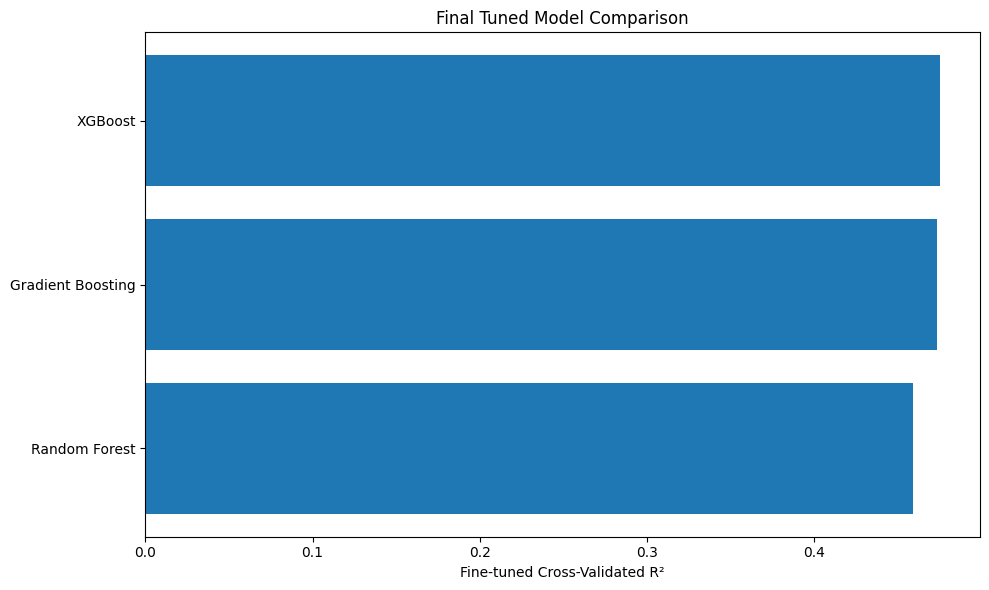

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(final_results["Model"], final_results["R²"])
plt.xlabel("Fine-tuned R²")
plt.title("Final Tuned Model Comparison")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../figures/final_tuned_models.png", dpi=300)
plt.show()

In [ ]:
best_model_name = final_results.iloc[0]["Model"]
best_model_parameters = final_results.iloc[0]["Best Parameters"]
best_model_r2 = final_results.iloc[0]["R²"]

print(f"Best Model: {best_model_name}")
print(f"Cross-Validated R²: {best_model_r2:.6f}")
print(f"Best Parameters:")
for parameter, value in best_model_parameters.items():
    print(f"  {parameter}: {value}")

Best Model: XGBoost
Cross-Validated R²: 0.475518
Validation R²: 0.462162
Best Parameters:
  model__subsample: 0.7
  model__reg_lambda: 1
  model__reg_alpha: 0.5
  model__n_estimators: 800
  model__min_child_weight: 10
  model__max_depth: 4
  model__learning_rate: 0.01
  model__gamma: 0
  model__colsample_bytree: 0.8


In [ ]:
final_model = build_pipeline(
    XGBRegressor(
        random_state=42,
        verbosity=0,
        n_jobs=-1,
        **{k.replace("model__", ""): v for k, v in best_model_parameters.items()}
    )
)

final_model.fit(X, Y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_engineering', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function fea...002058B5B8180>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",False
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keywor

## Feature Importance

In [ ]:
preprocessor = final_model.named_steps["preprocessor"]
model = final_model.named_steps["model"]

feature_names = preprocessor.get_feature_names_out()

importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

importance_df.head(15)

,Feature,Importance
0,num__depth,0.500590
27,num__yz_ratio,0.111917
9,num__b3,0.042364
26,num__xz_ratio,0.040860
7,num__b1,0.030567
2,num__a1,0.027709
5,num__a4,0.018486
4,num__a3,0.016203
29,cat__cut,0.010189
1,num__table,0.009762


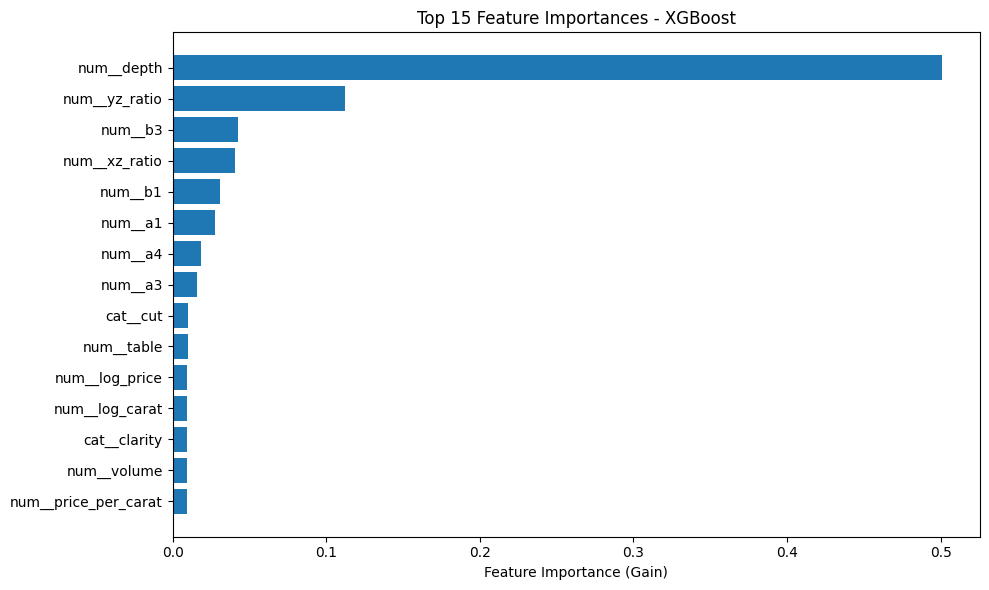

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(importance_df["Feature"][:15][::-1], importance_df["Importance"][:15][::-1])

plt.xlabel("Feature Importance (Gain)")
plt.title("Top 15 Feature Importances - XGBoost")
plt.tight_layout()
plt.savefig("../figures/feature_importance.png", dpi=300)
plt.show()
